In [1]:
from pyemma.msm import MaximumLikelihoodMSM, BayesianMSM, MaximumLikelihoodHMSM, its
from bhmm import lag_observations
import pyemma.plots as mplt
import pyemma.coordinates as coor
from msmbuilder.cluster import NDGrid
from sklearn.pipeline import Pipeline
import pickle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import entropy
import pandas as pd

/Users/robert_arbon/anaconda/envs/sonification/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/sonification/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/robert_arbon/anaconda/envs/sonification/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version.

In [2]:
results = pickle.load(open('h_state_selection.p', 'rb'))

In [3]:
df = pd.DataFrame(results)

In [4]:
df.head()

,aic,bic,dofs,entropy,icl,k,n_obs,tau
0,780111.451608,783811.876306,396,994.063572,785800.003449,2,84500,94
1,772364.754379,777934.080440,596,3460.459248,784854.998936,3,84500,94
2,769791.382984,777238.954915,797,12359.388510,801957.731934,4,84500,94
3,769855.506225,779190.668531,999,23058.148140,825306.964811,5,84500,94
4,769498.386385,778833.548692,999,22631.817189,824097.183069,6,84500,94


In [7]:
crit = df.loc[:, ['aic', 'bic', 'icl', 'k', 'tau']]

In [10]:
crit_melt = pd.melt(frame=crit, id_vars=['k', 'tau'], value_name='score', var_name='criterion')


In [14]:
min_scores = crit_melt.groupby(['tau', 'criterion'])['score'].transform('min')
idx = crit_melt['score'] == min_scores
best = crit_melt.loc[idx, :]
best

,k,tau,criterion,score
4,6,94,aic,769498.386385
11,7,37,aic,718217.280218
17,7,8,aic,643950.494145
23,7,5,aic,626166.037947
26,4,94,bic,777238.954915
32,4,37,bic,728611.684235
41,7,8,bic,657088.870724
47,7,5,bic,639304.414527
49,3,94,icl,784854.998936
56,4,37,icl,742423.064462


In [21]:
criteria = crit_melt['criterion'].unique()
taus = crit_melt['tau'].unique()

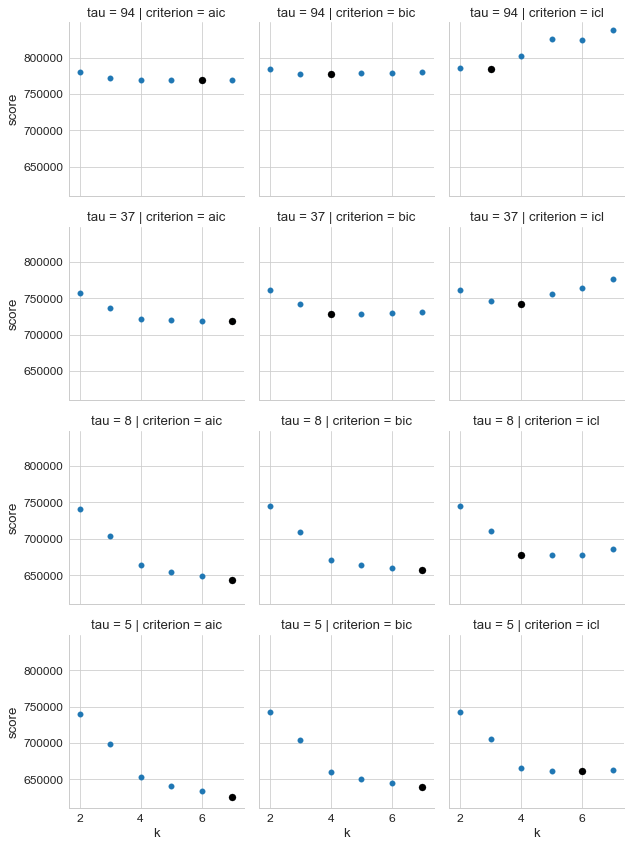

In [36]:
with sns.plotting_context('paper', font_scale=1.5):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(data=crit_melt, col='criterion',row='tau', col_order=criteria, row_order=taus, sharey=True)
    g.map(plt.scatter, 'k', 'score')
    for i, ax in enumerate(g.axes.flatten()):
        idx = (best['criterion']==criteria[i % len(criteria)]) & (best['tau'] == taus[int(i/len(criteria))])
        ax.scatter(best.loc[idx, 'k'],best.loc[idx, 'score'] , marker='o',s=50, color='k')
    # g.set(yscale='log')